### Abstract


Yelp reviews are a popular reference for gauging a restaurant's ability to provide a positive experience.  A Yelp review consists of a text review as well as a star rating that is on a range of 1-5 stars.  The shortcomings of a text review is that a review may contain sarcasm, ambiguity, or a play on words that can be misconstrued as positive or negative.  A sentiment classifier for reviews will remove the need for sentiment interpretation and replace the star rating system with the percentage of people that left a positive review.  The goal is to predict sentiment  (positive or negative) and the likelihood of a positive review from a text review and certain restaurant attributes because this removes the need for a star rating system that offers too many options and is more subjective than the binary option of sentiment.   

### Introduction

Leaving a review on Yelp is the most common way reviews for businesses are shared with potential visitors to a business. These reviews can greatly influence a potential visitor's decision to visit the restaurant. Sentiment prediction on a text review in Yelp provides clarity for the user on the meaning of the review and adds another metric in addition to the star based system. 

Sentiment prediction is not deterministic because a review can take on many forms.  However, the objective is to find a relationship between text review to sentiment, so that the likelihood of a review being positive can be predicted. 

The client interested in the results of this report is any company that currently accepts texts reviews for products or entities.  The client should care about sentiment prediction for these reviews because ambiguous reviews can be identified as positive or negative.  A viewer of the review is now clear on the intentions of the review when the sentiment is listed alongside the review.  With a sentiment classifier, a user of a review site will not have to leave a star rating because a positive or negative sentiment will automatically be generated from the review.  A site with reviews can offer a more conversational input style when describing a business that does not always require someone to state a star rating.  

The outline of this notebook and the machine learning notebook is summarized here with Section 2 introducing the data set.  In section 3, the data wrangling of the data set is summarized by explaining how the data set was obtained, cleaned, and wrangled.  In section 4, exploratory data analysis of the data is summarized by a field by field analysis of restaurant attributes that affect sentiment as well as identify words that are common in positive and negative reviews.  In section 5, the prediction task is described.  In the last section, section 6, conclusions and next steps are discussed.  

### Dataset 

The dataset was downloaded from, https://www.kaggle.com/yelp-dataset/yelp-dataset.  The data set was collected by Yelp and contains data concerning business attributes, reviews, users, checkins, and tips left by the user.  The data set contains 5.2 million user reviews across 174,000 businesses in 11 metropolitan areas. For this project only data from the business attributes and users files were used.   



Description of all the fields in the data set can be found at https://www.yelp.com/dataset/documentation/main.  

The Yelp dataset stores data in the json file format.  The following cell converts the json files into dataframes.  The json files are first converted into a list of strings where each string is a line in the json file.  The json files are converted to strings because the whole json file cannot be converted to a dataframe immediately since the json file contains multiple json objects.  After the json file is converted to strings, the strings are converted back to json format and stored in one list to be converted into a dataframe. 

In [1]:
import json
import pandas as pd

with open('yelp_academic_dataset_business.json') as businesses:      
    business = businesses.readlines()
    data_business = list(map(json.loads, business)) 

with open('yelp_academic_dataset_review.json') as reviews:
    review = reviews.readlines()
    data_review  = list(map(json.loads, review))
    
business_df=pd.DataFrame(data_business)
review_df=pd.DataFrame(data_review)



The dataset is subsetted to only feature restaurants that are in Las Vegas in order to decrease the computation time in the prediction task.  The business and review dataset are merged with a right merge so that every review for every business in Las Vegas is in one table.  Both the review and business table have a column named stars and are renamed so that when the join occurs, it's clear in the resulting dataset which column refers to an overall business rating or a individual review rating.  

In [2]:
lv_business=business_df[business_df.city == 'Las Vegas']
lv_business.dropna(subset=['categories'], inplace=True)

/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
lv_business=lv_business[lv_business['categories'].str.contains("Restaurants", na=False)]
lv_business=lv_business.rename(columns={'stars':'business_stars'})
review_df=review_df.rename(columns={'stars':'review_stars'})

lv_reviews=lv_business.merge(review_df, how='right', left_on='business_id', right_on='business_id')



Below is a list of columns in the joined dataset.


Important Field Descriptions:

attributes-dictionary of business attribute values such as price range and parking conditions <br>
categories-type of business <br>
is_open-0 or 1 if restaurant is closed or not <br>
review_count-number of reviews for a business <br>
business_stars-number of stars for the business (1-5 stars) and is average of individual reviews <br>
review_stars-number of stars for an individual review (1-5 stars) text-text review left by user <br>



In [4]:
lv_reviews.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'business_stars', 'state', 'cool', 'date', 'funny',
       'review_id', 'review_stars', 'text', 'useful', 'user_id'],
      dtype='object')

The prediction task is to use restaurant attributes and individual reviews to predict a business sentiment. Below is a distribution of the star ratings of all businesses in Las Vegas. The distribution illustrates a common trend in reviews in that there are more one star, four star, and five star ratings than other ratings because users tend to either give an extreme rating or not give a rating at all. Users tend to want to post if the service was either very good or very poor. In the data wrangling section, the star ratings will be converted into either a positive or negative sentiment.

1.0     6037
2.0     4401
3.0     6387
4.0    12145
5.0    21030
Name: review_stars, dtype: int64


Text(0,0.5,'Number of Ratings')

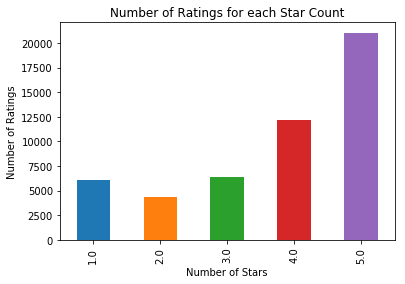

In [68]:
import matplotlib.pyplot as plt
star_counts=lv_reviews.review_stars.value_counts().sort_index()
print(star_counts)
star_counts.plot.bar(title='Number of Ratings for each Star Count')
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')

### Data Wrangling

Star ratings are converted into sentiment based on how a review's star rating is positioned on the scale of 1-5.  If the rating is above three, the review is classified as positive.  However if the rating is three or lower, meaning it is not positive, and either negative or neutral the review is classified as negative.  A user should go to a restaurant that is positively rated if they are choosing judiciously and want a good experience.  A three rating is not good enough to be positive because it is neutral.  A metric that can be listed on the Yelp website next to each review is the percentage of users that left a positive review, meaning a 4 or 5.  This dataset does not explicitly state whether all the reviews for a business are listed so calculating this value for now is not meaningful.  A four star rated restaurant could have 100 3 star ratings, not positive reviews, in the average for restaurant rating but does not show that 50% of users found the restaurant not positive.  

4402067 2283833


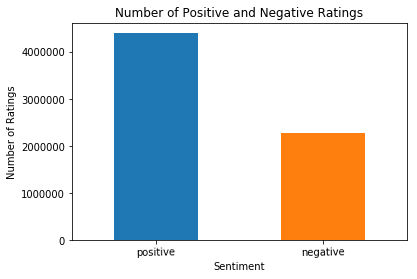

In [6]:
negative=[1.0, 2.0, 3.0]
positive=[4.0, 5.0]
negative_sum=0
positive_sum=0
for i in negative:
    negative_sum=star_counts[i]+negative_sum
for i in positive:
    positive_sum=star_counts[i]+positive_sum

sentiment=pd.Series([positive_sum, negative_sum], index=['positive', 'negative'])

sentiment.plot.bar(title='Number of Positive and Negative Ratings', rot=1)
plt.xlabel('Sentiment')
plt.ylabel('Number of Ratings')

print(positive_sum, negative_sum)

There are approximatley twice the number of positive ratings compared to the number of negative ratings. The positive and negative ratings are mapped to numerical format (1 and 0) respectively so that the machine learning models can process the target variable.  This dataset is not heavily imbalanced and accuracy as a classification metric in sentiment prediction does not need to be thrown out because the classes are not for example, 95% positive and 5% negative. 

In [20]:
lv_reviews['sentiment']=lv_reviews.review_stars.map({1.0:0, 2.0:0, 3.0:0, 4.0:1, 5.0:1})


The columns with missing values are listed below and missing values were subsequently dropped from the dataset. 

In [8]:
columns=lv_reviews.columns[lv_reviews.isna().any()].tolist()
columns

['address',
 'attributes',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'business_stars',
 'state']

The following columns are dropped because they do not aid in the prediction or data analysis sections.  The categories column is dropped because even though it does give information about the restaurant type, there are too many categories that a business can take on at once and makes it hard to group restaurants into a small number of groupings.

In [71]:
cols=['address', 'categories', 'city', 'hours', 'state', 'review_id', 'user_id']
for i in cols:
    try:
        lv_reviews=lv_reviews.drop(i, axis=1, inplace=False)
    except:
        continue
    

The text column with the reviews was already confirmed to have no missing values and doesn't have any empty strings as well.

In [10]:
lv_reviews[lv_reviews['text']==''].head(5)

,attributes,business_id,categories,city,is_open,latitude,longitude,name,postal_code,review_count,business_stars,cool,funny,review_stars,text,useful


The number of missing values per column with missing values is listed below. The large number of missing values in these columns is that the reviews were joined on only restaurants in Las Vegas so that rest of the reviews now contain null values for restaurant attributes.  

In [11]:
print('The number of null values in the attributes column is: ' + str(lv_reviews['attributes'].isnull().sum()))
print('The number of null values in the categories column is: ' + str(lv_reviews['categories'].isnull().sum()))
print('The number of null values in the city column is: ' + str(lv_reviews['city'].isnull().sum()))
print('The number of null values in the is_open column is: ' + str(lv_reviews['is_open'].isnull().sum()))
print('The number of null values in the latitude column is: ' + str(lv_reviews['latitude'].isnull().sum()))
print('The number of null values in the name column is: ' + str(lv_reviews['name'].isnull().sum()))
print('The number of null values in the postal_code column is: ' + str(lv_reviews['postal_code'].isnull().sum()))
print('The number of null values in the review_count column is: ' + str(lv_reviews['review_count'].isnull().sum()))
print('The number of null values in the business_stars column is: ' + str(lv_reviews['business_stars'].isnull().sum()))





The number of null values in the attributes column is: 5446555
The number of null values in the categories column is: 5443189
The number of null values in the city column is: 5443189
The number of null values in the is_open column is: 5443189
The number of null values in the latitude column is: 5443189
The number of null values in the name column is: 5443189
The number of null values in the postal_code column is: 5443189
The number of null values in the review_count column is: 5443189
The number of null values in the business_stars column is: 5443189


All rows with missing values are removed.

In [12]:
lv_reviews=lv_reviews.dropna()

In order to decrease exploration and prediction time, a representative sample of the population was chosen by selecting 50,000 reviews  randomly without replacement from the dataset.  In addition, outliers were checked for in numerical columns and there appears to be no negative values and in the case of ratings no values above five.  

In [13]:
lv_reviews=lv_reviews.sample(n=50000)
lv_reviews.to_csv('lv_reviews')


In [80]:
import pandas as pd
lv_reviews=pd.read_csv('lv_reviews')


In [81]:
cols=['useful', 'funny', 'cool', 'review_stars', 'review_count']
counter=1
for i in cols:
    if i == 'review_stars':
        if any(lv_reviews[i]>0) and any(lv_reviews[i]<5):
            counter+=1
            continue
    if any(lv_reviews[i]>0):
        counter+=1
if counter == (1+len(cols)):
        print('These columns have no negative values and in the case of review_stars no values above five, therefore there are no outliers.')

These columns have no negative values and in the case of review_stars no values above five, therefore there are no outliers.


In [82]:
lv_reviews=lv_reviews.drop(['Unnamed: 0'], axis=1, inplace=False)


#### Feature Engineering

The average star rating by itself does not give a full picture of how good a restaurant by itself.  The number of reviews need to be taken into account as well since it is a measure of restaurant popularity.  A bayesian average formula smoothes the restaurant rating by accounting for the prior rating as well as the total number of stars given to a restaurant.  The formula for this better way to rank restaurants is listed below and is currently used to determine the IMDB top 250 movie rankings.  


Bayesian Average 


$$Average = \frac{C*m + total stars}{C + number of reviews}$$

where,

C=prior number of observations <br>
m=prior average of stars

In [83]:
lv_reviews.groupby('business_id').mean().mean()

C=250.686488
m=3.541773

lv_reviews['bayes_avg']=(C*m+lv_reviews['review_count']*lv_reviews['business_stars'])/(C+lv_reviews['review_count'])


The attributes column contains dictionaries with many attributes for each restaurant and not all of them apply to each restaurant.  An interesting attribute that may affect restaurant sentiment is the price range that is given on a scale of 1-4.  The price range is extracted from the attribute dictionary of each restaurant and added as a new feature in the dataframe.  



In [84]:
import ast
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val
lv_reviews['attributes'] = lv_reviews['attributes'].apply(literal_return)


In [85]:
price=[]
for i in range(len(lv_reviews)):
    try:
        price.append(int(lv_reviews['attributes'][i]['RestaurantsPriceRange2']))
    except:
        price.append(2)
        

lv_reviews['price_range']=price

    
    

### Exploratory Data Analysis


The distribution of values in a restaurant's attribute and how it affects restaurant sentiment is explored in this section. Also, the "best" restaurants will be ranked according the the Bayes average feature created in the data wrangling section.   In addition, a word2vec model will be trained with the text reviews and similar words in the text for positive and negative words will be found.  

The Bayes average of restaurant rating is a more representative measure of how good a restaurant is compared to just number of reviews or star rating.  The Bayes averages were computed for all of the restaurants and the top five scores were plotted.  These scores reflect the restaurants with the best combination of popularity and score.  

The top restaurants by the number of reviews left were also found and when comparing to the Bayes average rating, none of the restaurants in the top five for both rankings systems are the same restaurant.  Taking into account both star rating and number of ratings intuitively seems more prudent when deciding on a restaurant to visit.  

Text(0,0.5,'Number of Reviews')

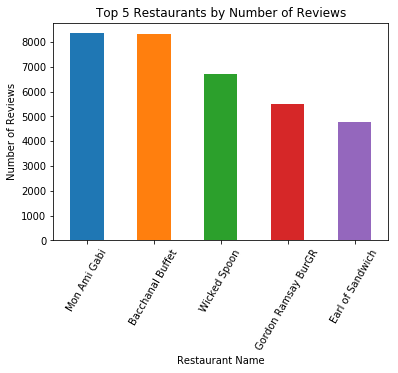

In [86]:
import matplotlib.pyplot as plt
review_count=lv_reviews.groupby('name').mean()['review_count'].sort_values(ascending=False).head(5)
review_count.plot.bar(title='Top 5 Restaurants by Number of Reviews', rot=60)
plt.xlabel('Restaurant Name')
plt.ylabel('Number of Reviews')

In [87]:
bayes_avg_series=lv_reviews.groupby('business_id').mean()
top_20=bayes_avg_series.sort_values('bayes_avg', ascending=False).head(20)

                               bayes_avg_y
name                                      
Brew Tea Bar                      4.791905
Earl of Sandwich                  4.454895
Yardbird Southern Table & Bar     4.437226
Gangnam Asian BBQ Dining          4.435072
Egg & I                           4.432347


Text(0,0.5,'Bayes Average')

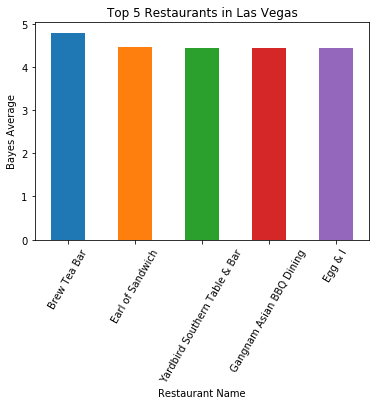

In [88]:

top_20_names=top_20.merge(lv_reviews, how='left', left_index=True, right_on='business_id')


top_20_restaurants=top_20_names[['name', 'bayes_avg_y']].groupby('name').mean().sort_values(by='bayes_avg_y', ascending=False)

print(top_20_restaurants.head(5))

top_5=top_20_restaurants.head(5)['bayes_avg_y']
top_5.plot.bar(title='Top 5 Restaurants in Las Vegas', rot=60)
plt.xlabel('Restaurant Name')
plt.ylabel('Bayes Average')



In addition to restaurant text reviews, restaurant attributes will be used in the prediction model for sentiment 

#### Restaurant and Review Attributes

#### A.) Restaurant Operation Status

Restaurants are either open or closed and are listed as a feature in the business dataset.  The graph below shows that open restaurants have a higher rate of positive reviews than closed restaurants.  This makes sense because closed restaurants may have closed due to negative reviews.  The difference in rate of positive reviews between the values of the feature can be used as a predictor for review sentiment in a machine learning model.

Text(0,0.5,'Rate of Positive Reviews')

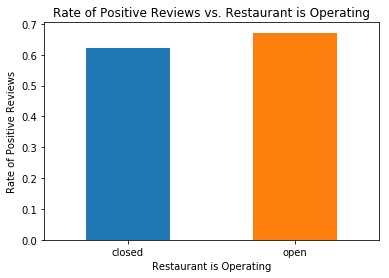

In [89]:
lv_reviews['sentiment']=lv_reviews.review_stars.map({1.0:0, 2.0:0, 3.0:0, 4.0:1, 5.0:1})
is_open=lv_reviews.groupby('is_open').mean()['sentiment']
is_open.index=['closed', 'open']
is_open.plot.bar(title='Rate of Positive Reviews vs. Restaurant is Operating', rot=0)
plt.xlabel('Restaurant is Operating')
plt.ylabel('Rate of Positive Reviews')

#### B.) Restaurant Review Count
Restaurant review count is one measure of a restaurant's popularity and it is important to check if restaurant review count is positively correlated with rate of positive reviews for the restaurant. The graph below shows that the slope of the best fit line between the two variables is very small and is 2e-5.  In addition, the Pearson correlation coefficient is small and does shows a very weak positive linear correlation.  The low positive linear correlation between restaurant review count and rate of postive reviews is low and shows that restaurant review count will be a weak predictor in a machine learning model.

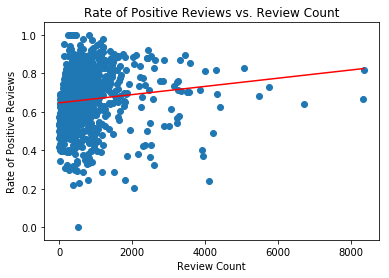

2.1335777059533938e-05


(0.1274179418903221, 0.00010196230192520253)

In [90]:
import numpy as np
from scipy.stats import pearsonr

review_count=lv_reviews.groupby('review_count').mean()['sentiment']

plt.scatter(review_count.index, review_count)
plt.title('Rate of Positive Reviews vs. Review Count')
plt.xlabel('Review Count')
plt.ylabel('Rate of Positive Reviews')

m, b = np.polyfit(review_count.index, review_count, 1)
plt.plot(review_count.index, b + m * review_count.index, '-', color='red')
plt.show()

print(m)


pearsonr(review_count.index, review_count)

#### C.) Price Range
Restaurants have a price range from a scale of 1-4 and the scale is listed as a feature in the business dataset. The graph below shows that  restaurants with a price rating of four have a higher rate of positive reviews than price ranges between (1-3). This makes sense because more expensive restaurants tend to give better food and service. The difference in rate of positive reviews between the values of price range can be used as a predictor for review sentiment in a machine learning model.

Text(0,0.5,'Rate of Positive Reviews')

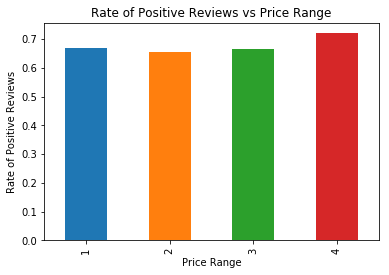

In [91]:
review_count=lv_reviews.groupby('price_range').mean()['sentiment']

review_count.plot.bar(title='Rate of Positive Reviews vs Price Range')

plt.xlabel('Price Range')
plt.ylabel('Rate of Positive Reviews')

#### D.) Review Impressions
Restaurants reviews have a review reaction of the possibilities that the review is useful, cool, or funny and the number of these reactions per review are listed as features in the review dataset. The graph below shows that there are more positive reviews with useful, cool, and funny ratings. Also, most reviews have a small amount of reactions, less than 20, and the distribution of reaction count for positive vs negative reviews is different. The difference in the distribution of cool, funny, and useful  reviews for positive and negative reviews can be used as predictors for review sentiment in a machine learning model.

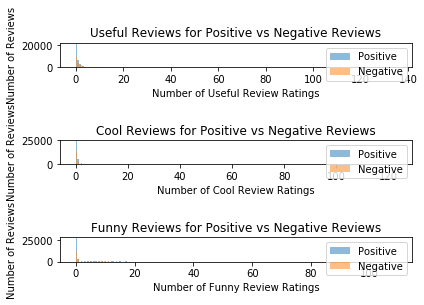

In [92]:
import seaborn as sns
import matplotlib.pyplot as pyplot

fig=pyplot.figure()
fig.add_subplot(3, 1, 1)

useful_1=lv_reviews[lv_reviews['sentiment']==1]['useful'].tolist()
useful_0=lv_reviews[lv_reviews['sentiment']==0]['useful'].tolist()

pyplot.hist(useful_1, alpha=0.5, bins=200, label='Positive')
pyplot.hist(useful_0, alpha=0.5, bins=200, label='Negative')

plt.title('Useful Reviews for Positive vs Negative Reviews')
plt.xlabel('Number of Useful Review Ratings')
plt.ylabel('Number of Reviews')
plt.legend(loc='upper right')


fig.add_subplot(3, 1, 2)

cool_1=lv_reviews[lv_reviews['sentiment']==1]['cool'].tolist()
cool_0=lv_reviews[lv_reviews['sentiment']==0]['cool'].tolist()

pyplot.hist(cool_1, alpha=0.5, bins=200, label='Positive')
pyplot.hist(cool_0, alpha=0.5, bins=200, label='Negative')

plt.title('Cool Reviews for Positive vs Negative Reviews')
plt.xlabel('Number of Cool Review Ratings')
plt.ylabel('Number of Reviews')
plt.legend(loc='upper right')

plt.title.labelpad = 5000

fig.add_subplot(3, 1, 3)

funny_1=lv_reviews[lv_reviews['sentiment']==1]['funny'].tolist()
funny_0=lv_reviews[lv_reviews['sentiment']==0]['funny'].tolist()

pyplot.hist(funny_1, alpha=0.5, bins=200, label='Positive')
pyplot.hist(funny_0, alpha=0.5, bins=200, label='Negative')

plt.title('Funny Reviews for Positive vs Negative Reviews')
plt.xlabel('Number of Funny Review Ratings')
plt.ylabel('Number of Reviews')
plt.legend(loc='upper right')

plt.tight_layout(h_pad=2.5)
plt.show()



#### E.) Geographic Representations

Below is a map of Las Vegas Restaurants and their locations according to their latitude and longitude. There tends to be more reviewed restaurants  in the center of the city as opposed to the edges.  

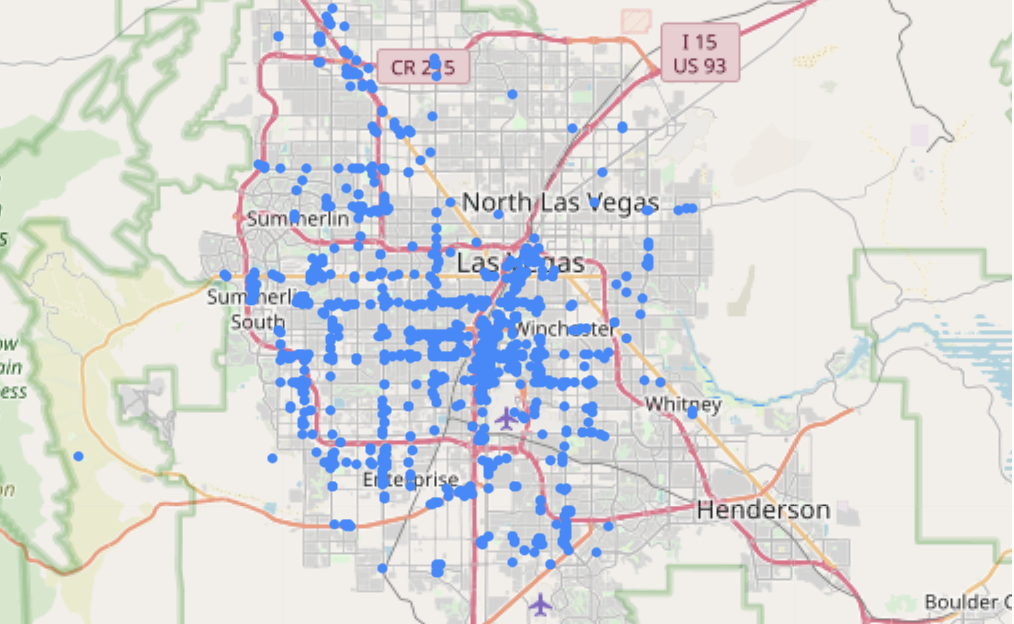

In [252]:
import folium as folium
from IPython.display import Image

lv_long_lat=lv_reviews.groupby('business_id').mean()[['latitude', 'longitude', 'sentiment']].sort_values(by='sentiment').sort_index()
lv_long_lat=lv_long_lat.sample(2800)

coord=[]

for i in range(len(lv_long_lat)):
    lat=lv_long_lat['latitude'][i]
    long=lv_long_lat['longitude'][i]
    coord.append([lat,long])
    

mapit = None
mapit = folium.Map( location=[lv_reviews['latitude'].mean(), lv_reviews['longitude'].mean()])

for i in coord:
        folium.vector_layers.CircleMarker(i, radius=1).add_to(mapit)
    
        
mapit.save( 'map.html')
Image('Screen Shot 2019-02-12 at 9.20.37 AM.png')

Below is a heat map of average restaurant sentiment across zip codes in the dataset. It is interesting to note that as the distance from the center of Las Vegas increases, restaurant sentiment seems to be going down. There are 63 zip codes in the dataset and it would not make sense to hot one encode these for prediction as too many new features would be created but it is still interesting to see that zip code affects restaurant sentiment.

In [ ]:
lv_reviews['postal_code']=lv_reviews['postal_code'].replace(np.nan, 0)
lv_reviews['postal_code']=lv_reviews['postal_code'].astype(int).astype(str)
    
                                                            
postal_codes=lv_reviews.groupby('postal_code').mean()['sentiment']
postal_codes.head(5)

In [ ]:
import json 
with open('nv_nevada_zip_codes_geo.min.json', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

geozips=[]
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZCTA5CE10'] in lv_reviews.postal_code.unique():
        geozips.append(tmp['features'][i])

new_json=dict.fromkeys(['type', 'features'])
new_json['type']='FeatureCollection'
new_json['features']=geozips

open('updated-file.json', "w").write(json.dumps(new_json, indent=4, separators=(',', ': ')))



In [117]:
def create_map(zipcode_data, col):
    lv_geo=zipcode_data
    m = folium.Map( location=[lv_reviews['latitude'].mean(), lv_reviews['longitude'].mean() ] )
    m.choropleth(geo_data=lv_geo, fill_opacity=0.7,
                    line_opacity=0.2, fill_color='RdYlGn', data=postal_codes,
                  columns=[postal_codes.index, postal_codes], 
                  key_on='feature.properties.ZCTA5CE10',
                 legend_name='restaurant ' + col)

    folium.LayerControl().add_to(m)
    m.save(col + '.html')
    
    return m
    


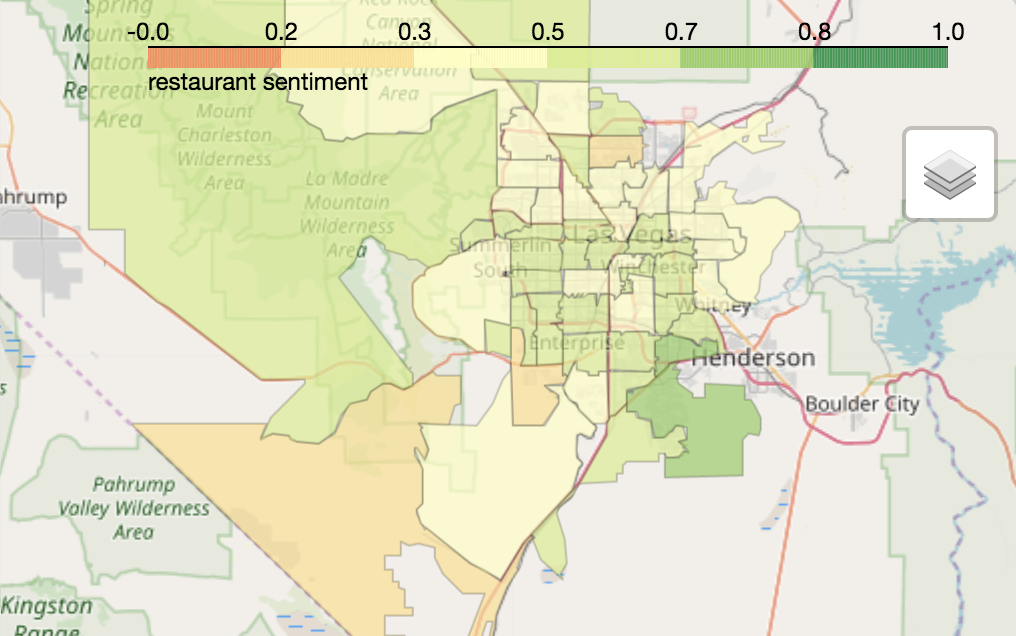

In [253]:
Image('Screen Shot 2019-02-12 at 9.20.14 AM.png')

##### Sentiment Analysis 

#### A.) TextBlob

TextBlob is a NLP package that allows for sentiment analysis and was done to find the most common words in positive and negative reviews. Before TextBlob could process the reviews, all of the reviews had non letter and space characters removed and lower cased.  Aftwerwards, all stopwords, common words in the english language, were removed to avoid giving significance to common words.  TextBlob then returns sentiment polarity for each review based on the sentiment of the words inside of it.  According to TextBlob, there were 43,879 reviews that were positive out of 50,000 reviews.  A wordcloud was then constructed to show the most common words in positive and negative reviews.

In [189]:

from wordcloud import WordCloud, STOPWORDS
import re
import string
import nltk
from textblob import TextBlob

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation)
stopwords=set(i).union(j)

def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())
    x = [w for w in x.split() if w not in set(stopwords)]
    return ' '.join(x)

top_all=lv_reviews.name.value_counts()
yelp_top_reviewed_biz=lv_reviews.loc[lv_reviews['name'].isin(top_all.index)]
yelp_top_reviewed_biz['text_processed']=yelp_top_reviewed_biz['text'].apply(preprocess)




In [190]:
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

yelp_top_reviewed_biz['text_score']=yelp_top_reviewed_biz['text_processed'].apply(sentiment)

In [198]:
yelp_top_reviewed_biz['text_score'][yelp_top_reviewed_biz['text_score'] > 0]=1
yelp_top_reviewed_biz['text_score'][yelp_top_reviewed_biz['text_score'] < 0]=0

yelp_top_reviewed_biz.text_score.value_counts()

/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    43879
0.0     6121
Name: text_score, dtype: int64

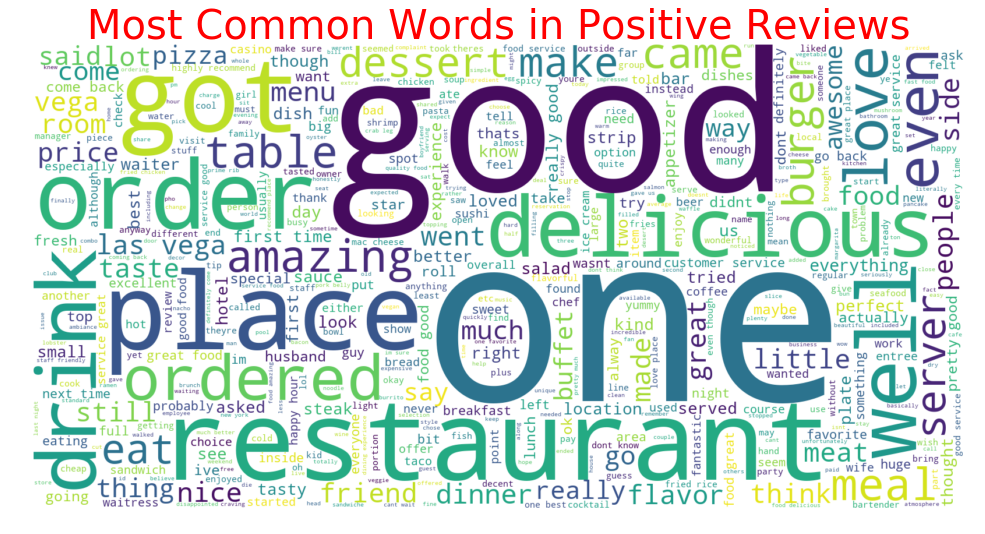

In [201]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(yelp_top_reviewed_biz['text_processed'][yelp_top_reviewed_biz['text_score']==1.0])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Most Common Words in Positive Reviews", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

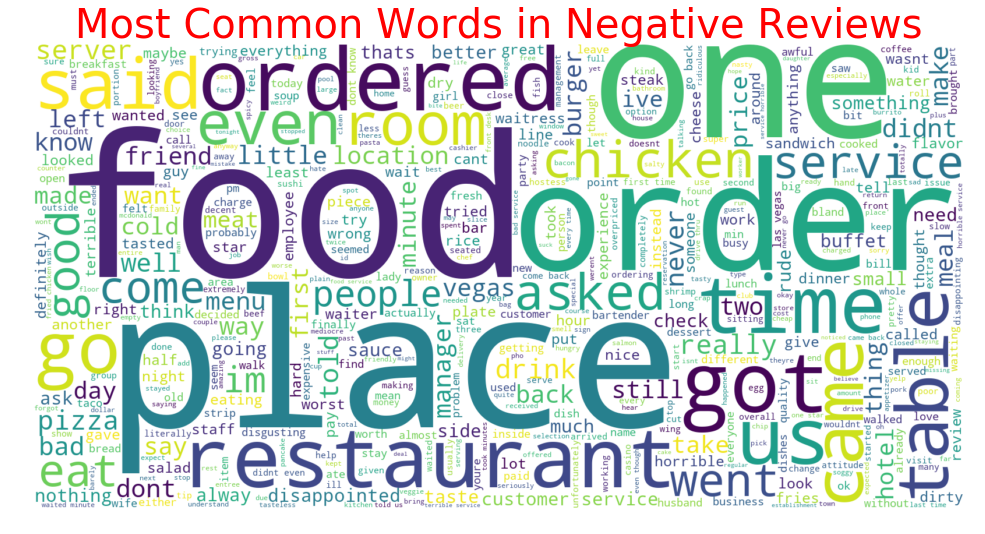

In [203]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(yelp_top_reviewed_biz['text_processed'][yelp_top_reviewed_biz['text_score']==0.0])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Most Common Words in Negative Reviews", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

#### B.) Word2Vec

Word2Vec is a neural network implementation that learns distributed representations for words.  A vector of a specified size, in this case 300, was used to represent each word in the model's vocabulary fed into by the sentences of the reviews.  A Word2Vec model was run on the reviews after they were processed by first removing non letters but stopwords were kept because these give structure and context to a Word2Vec model as it uses external text to create a vector.  


Parameters for Word2Vec model:
Downsampling of Frequent Words-Frequent words should not take on more importance just because they occur often because they are most likely stop words.  Google documentation recommends values between 0.0001 and 0.001, the value chosen was 0.001. <br>
Word vector dimensionality-The dimesnionality of the word vector was chosen to be 300, the more features used results in longer run times but not always better models. <br>
Minimum word count-Any word that does not occur at least this many times across all documnts is ignored.  The value 35 was chosen because each restauarant appears on average 20 times, and a value larger than that is used to limit the size of the vocabulary to meaningful words.   <br>
Window size-The number of words for context that the training algorithm should take into account, tne was chosen for this parameter.  <br>


The resulting WordVec model produces a matrix where each row is a word that appears in the review and the columns are the vector representation for that word. After the model was run, based on its vector representations of the words in the sentences of the reviews, the most similar words to great (positve and awful (negative) were found.  Word2vec appears to be working and trained on a large enough training set basd on the synonyms produced.  

In [220]:
import re
from nltk.corpus import stopwords
import nltk.data



def review_to_wordlist(review, remove_stopwords=False):
    #Function that converts a document to a sequence of words and 
    #removes stop words
    review_text=review
    #Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    #Convert words to lower case and split 
    words=review_text.lower().split()
    #Remove stop words
    if remove_stopwords:
        stops=set(stopwords.words("english"))
        words=[w for w in words if not w in stops]
    return(words)
    
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    #Function that splits a review into parsed sentences.  Returns 
    #list of sentences where each sentence is a list of words
    raw_sentences=tokenizer.tokenize(review.strip())
    
    sentences=[]
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords=False))
    return sentences
            
            
sentences=[]

print('Parsing sentences from dataset')
for review in lv_reviews['text']:
    sentences += review_to_sentences(review, tokenizer)
    

Parsing sentences from dataset


In [ ]:
import logging 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

#Set values for parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 35   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3 

from gensim.models import word2vec
model=word2vec.Word2Vec(sentences, workers=num_workers,
                       size=num_features, min_count=min_word_count,
                        window=context, sample=downsampling)
model.init_sims(replace=True)

model_name="300features_40minwords_10context"
model.save(model_name)

In [236]:
model.most_similar("awful")

/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('terrible', 0.8226549625396729),
 ('horrible', 0.8048520684242249),
 ('alright', 0.7285017371177673),
 ('disgusting', 0.7106912136077881),
 ('subpar', 0.7092010974884033),
 ('sucked', 0.6660960912704468),
 ('gross', 0.6531112790107727),
 ('lousy', 0.6510778665542603),
 ('stellar', 0.646142303943634),
 ('lacking', 0.6347830295562744)]

In [237]:
model.most_similar("great")

/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/sooryapaturi/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fantastic', 0.8009390234947205),
 ('wonderful', 0.773438036441803),
 ('fabulous', 0.7601549625396729),
 ('terrific', 0.7351025342941284),
 ('excellent', 0.7282377481460571),
 ('awesome', 0.7204433679580688),
 ('phenomenal', 0.6875117421150208),
 ('amazing', 0.6724933385848999),
 ('exceptional', 0.6698110103607178),
 ('outstanding', 0.6648397445678711)]